<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Analyzing_and_Improving_the_Image_Quality_of_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing and Improving the Image Quality of StyleGAN**

논문 링크: https://arxiv.org/abs/1912.04958

StyleGAN2는 기존 StyleGAN의 두가지 문제점 droplet artifacts, phase artifacts을 해결하기 위해 제안이 되었다.

## **Droplet artifacts**

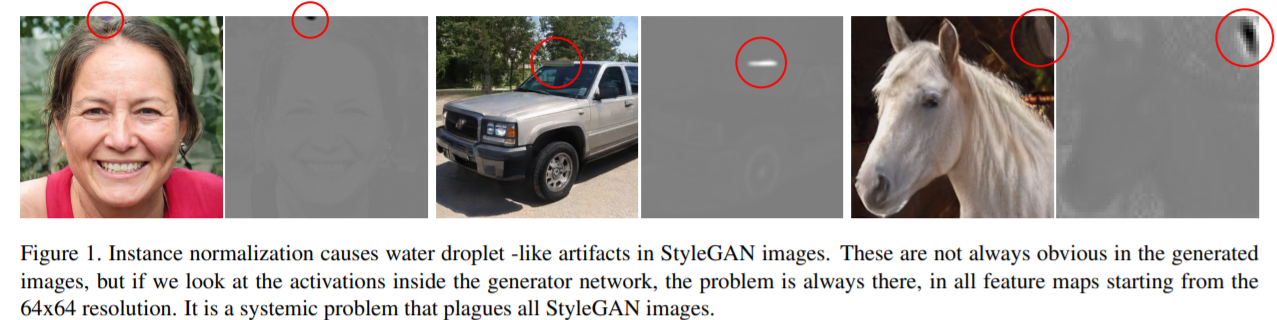

위의 그림 Figure 1을 보면 feature map에 빨간색 원으로 표시가 된 **물방물 같은 결함(water droplet-like artifacts)**이 64 x 64 resolution의 image에서 보이기 시작하며, 이후 점점 강해진다. 그리고 이러한 artifacts가 존재하지 않는 경우는 아예 잘못된 image가 생성되어 버린다. discriminator가 이를 왜 잡아내지 못했는지에 대해선 미지수이다.

본 논문에서는 이 문제의 원인으로 **AdaIN**을 지목하였다. AdaIN은 feature map마다 평균과 분산으로 normalization을 한다. 그런데 이러한 AdaIN이 너무 강하기 때문에 잠재적으로 feature들 사이에 상대적인 크기에서 발견되는 정보들을 파괴한다.

위의 사항에 대해 파악하기 위해  generator가 의도적으로 몰래 이전의 IN에 강한 신호를 준다는 가설을 세웠다. 

기존 StyleGAN에서는 AdaIN이 feature map의 평균과 분산을 normalization했지만, **StyleGAN2에서는 convolution weight를 normalization**한다. AdaIN에서 평균을 제거하고 표준편차만 사용하였으며, 표준편차만으로도 충분하다는 것을 파악하게 되었다.

뿐만아니라 bias와 noise를 block 외부로 빼내어 style과 noise의 영향력을 독립시켰다. 기존에 noise의 영향력이 style의 크기에 반비례하였다면, 이를 통해 noise의 변화에 따른 효과가 분명해졌다. 이는 IN과 수학적으로 동일한 방법은 아니지만, output feature map을 standard unit standard deviation을 갖도록 해주어 train을 안정시킨 덕분에 결과적으로 물방울 artifact를 없앴다.

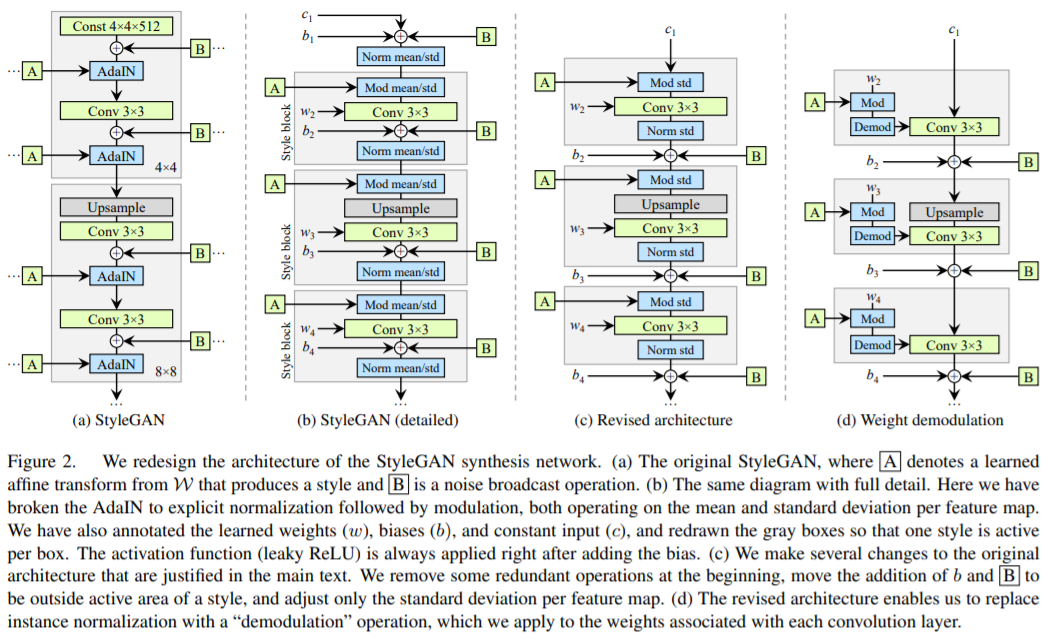

위의 그림 Figure 2를 보면 먼저 (b) 부분과 같이 StyleGAN의 핵심인 Style block을 단순화하는 것으로 시작한다. AdaIN을 간단하게 요약하자면, 첫번째는 content 정보를 자신의 통계량으로 정규화 하는 것이며 두번째는 정규화된 content 정보를 style의 정보를 이용해 선형 변환하는 것이다. AdaIN 부분을 적절하게 수정한 것이 (b) 부분인데, AdaIN 내부의 조작은 content 정규화 후 style vector에 의한 선형 변환으로 이루어지지만, **style block의 중간에서는 style vector에 의한 선형 변환 후 convolution을 거친 다음에 content 정규화**가 된다.

다음으로 (c) 부분은 평균치를 사용한 조작은 불필요하다고 여기어 **정규화를 단순 표준편차만 이용**하는 것으로 그치기 때문에 style의 선형 변환도 역시 단순하게 계수를 곱하는 것만 진행을 한다. 그리고 **noise의 input 부분이** style block 내부에 위치할 필요가 없기 때문에 **외부로 옮겼다**.

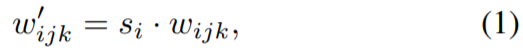

이것으로 style block내의 조작을 단순화 시킬 수 있는데, 제일 처음의 style vector에 대한 선형 변환을 convolution 내부의 처리로 실시하는 것을 고려한다. style block 내에서는 style vector w를 선형 변환한 y_s라는 계수를 곱하고 있다. content image s를 곱하는 것을 convolution의 weight w_ijk로 처리하는 조작은 content image를 weight w_ijk와 s의 곱으로 convolution한 것과 동일하다. 이에 대한 설명은 위의 식과 같다. 위의 그림 Figure 2 (d) 부분의 Mod(modulation)에 해당한다.

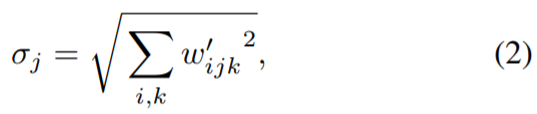

그 다음으로는 위의 식과 같이 convolution 내부 처리에서 normalization 작업을 수행한다. 이때 input이 표준 정규분포와 out의 표준 편차를 따른다.

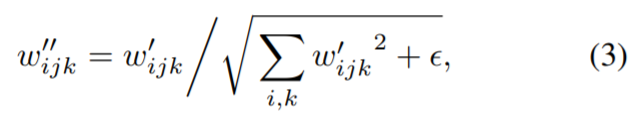

여기서 원하는 작업은 표준 편차의 역수로 output을 곱하는 것이다. 즉, weight w_ijk와 convolution의 곱셈에 표준 편차의 역수를 곱한 작업인데, 아는 곧 표준 편차의 역수에 곱한 weight w_ijk와 convolution하는 것과 같다. 이 작업은 위의 식과 같이 진행이 된다. 위의 그림 Figure 2 (d) 부분의 Demod(demodulation)에 해당한다.

다시 최종적으로 정리하면 style block의 순서는 style에 의한 선형 변환(linear transformation) 후 convolution을 진행하고 출력을 정규화(normalization)하는 작업이 하나의 convolution process가 된다.

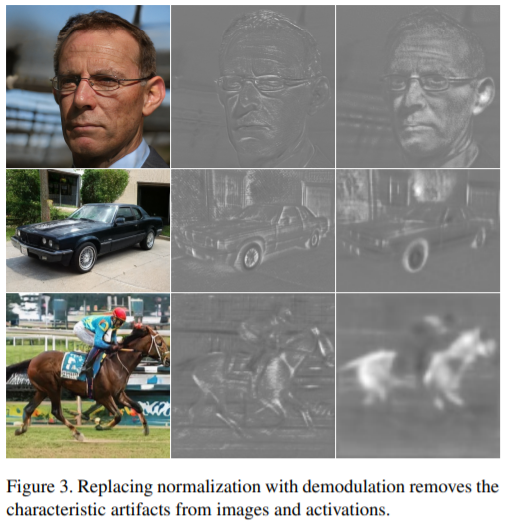

이로 인한 결과는 위의 Figure 3과 같은데, water droplet-like artifacts가 더 이상 나오지 않는다.

## **Phase artifacts**

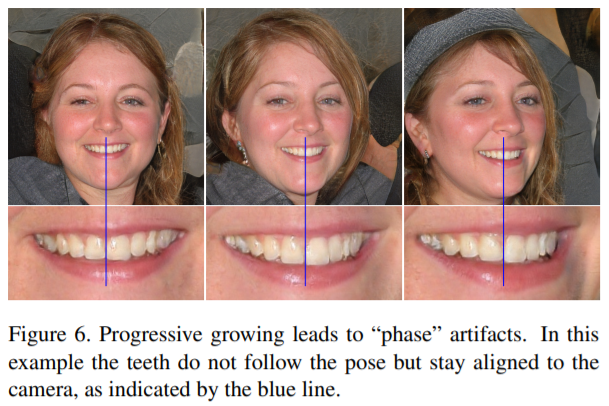

위의 그림 Figure 6을 보면 일부 feature들이 얼굴의 움직임을 따르지 않는 **phase artifacts**가 발생하는 것을 알 수 있다. 왼쪽 그림으로부터 오른쪽 그림으로 얼굴의 방향은 옆으로 변하지만, 이의 배열은 얼굴을 따르지 않아 부자연스럽게 느껴진다. 본 논문에서는 이러한 문제가 **progressive growing**으로 인해 발생한다고 주장한다.

progressive growing은 high-resolution image를 생성하기 위해 generator와 discriminator를 점차적으로 추가하는 방법이다. 그러나 각 generator는 독립되어 있기 때문에 위의 그림과 같이 이가 얼굴을 따라하지 않는 frequent features를 생성하기 경향이 있는 것이다.

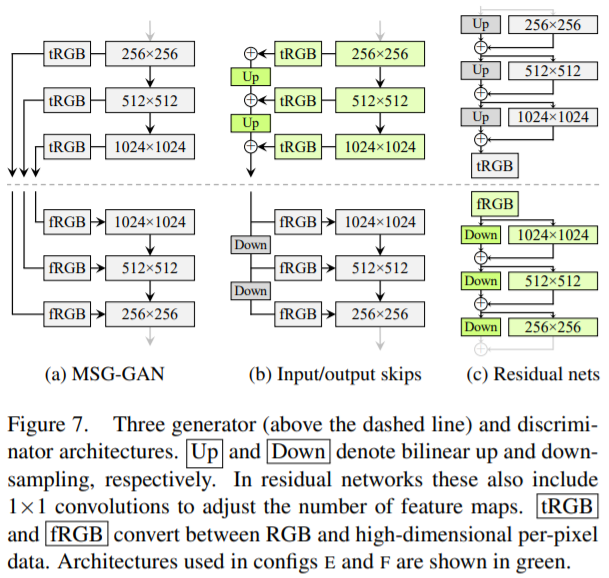

따라서 본 논문에서는 위의 그림 Figure 7과 같이 progressive growing을 사용하지 않고 high-resolution image를 생성하는 방법을 제안했다. network의 구조는 (a) 부분에 나와있는 MSG-GAN과 유사한데, (b) 부분의 generator와 discriminator 그리고 (c) 부분의 generator와 discriminator의 모든 조합을 실험하였다.

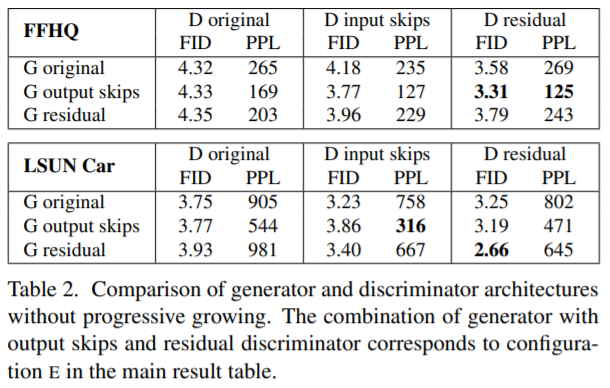

위의 표 Table 2의 결과가 바로 실험의 결과이다. 먼저 (b) 부분의 generator를 사용하는 것이 PPL을 상당히 개선했으며, (c) 부분의 discriminator를 사용하는 것이 FID를 개선하였다.

progressive growing 기반 network는 처음 low-resolution image를 생성하고 점차 resolution을 증가하는 방식이었다. 과연 본 논문에서 제시한 network도 이러한 방식의 train을 진행할까?

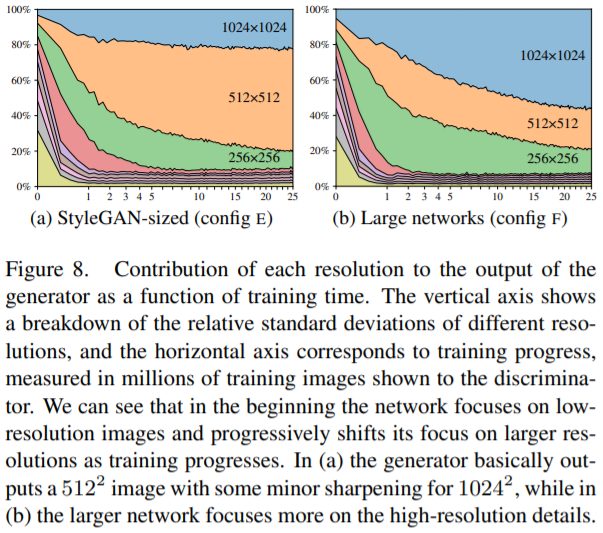

이에 대한 답은 위의 그림 Figure 8을 보면 알 수 있다. 먼저, (b) 부분의 generator의 경우 생성된 각 resolution image를 더하기 때문에 각 resolution image가 최종으로 생성된 image에 기여가 된다. 위의 그래프에서 세로축은 각 resolution의 기여도를 나타내며, 가로축은 train의 진전도를 가르킨다.

위의 그림 Figure 8에서 (a) 부분을 보면 high-resolution 쪽에 대한 기여도는 train이 진전됨에 따라 증가하며, (b) 부분을 보면 network의 크기가 증가할때 high-resolution의 기여도가 훨씬 증가하였다.

## **Path Length Regularization**

image.png

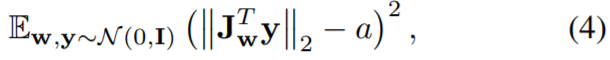

잠재 공간의 지각적 매끄러움(perceputal smoothness)을 나타내는 PPL과 image 품질 사이에 상관관계가 있기 때문에 위의 식과 같이 이를 regularization term으로 통합하였다. 이때 a는 상수고 y는 정규 분포로부터 생성된 random image이다. 이 regularization은 generator가 가능한 한 잠재 변수의 섭동(perturbation)으로 인한 변화를 최소화하도록 한다. train은 첫번째 항의 평균을 움직여 상수 a를 동적으로 바꾸면서 수행하여 train 중 최적의 값을 설정한다.

## **Experiments**

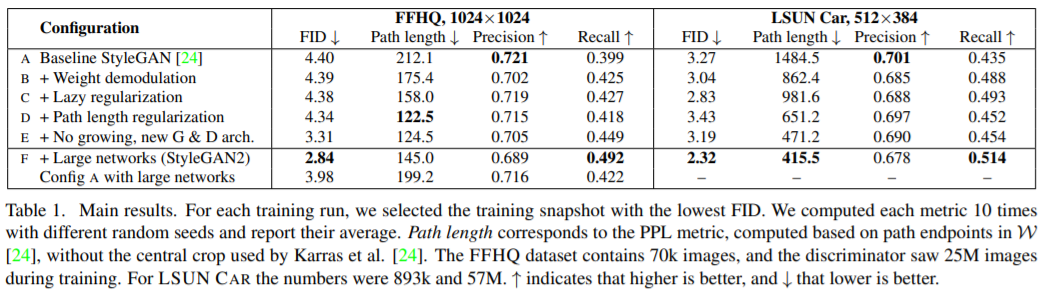

위의 표 Table 1은 두 dataset에 각 방법이 도입이 될시 성능이 어떻게 변화하는지 나타낸 것이다. C 부분의 Lazy regularization은 regularization term을 자주 업데이트하지 않는 것이다. Lazy하여도 결과는 좋은 것을 알 수 있다. F는 지금까지 설명한 방법 외에 network size를 늘린 것이다. convolution 안에 lazy regularization과 AdaIN을 통합하면 학습 시간이 확실히 빨리진 것을 알 수 있다. 덕분에 network의 size 또한 키울 수 있다.

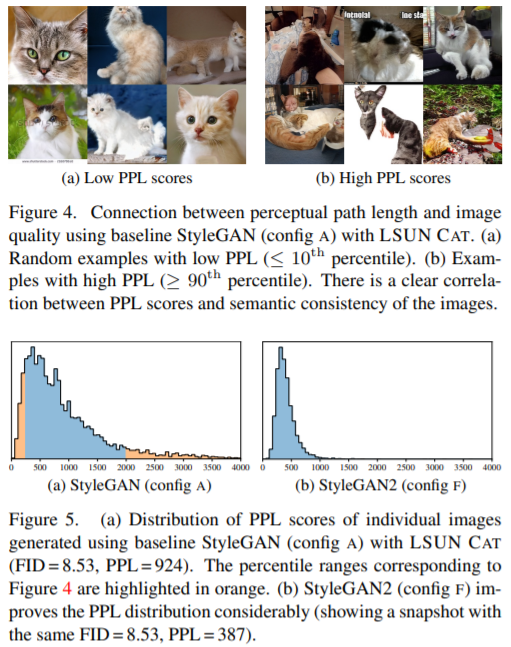

위의 그림 Figure 4와 5를 보면 StyleGAN2를 통하여 품질이 향상된 것을 알 수 있다. (PPL이 낮을수록 Image의 품질이 올라간다.)

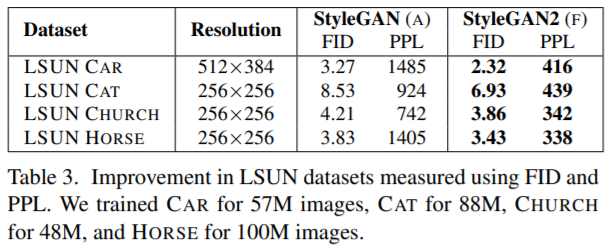

위의 표 Table 3을 보면 LSUN daataset에 관하여 StyleGAN과 StyleGAN2의 성능을 FID와 PPL로 비교한 것이다. StyleGAN2가 모든 LSUN dataset 종류와 resolution에 대해 성능이 더 우수하다.

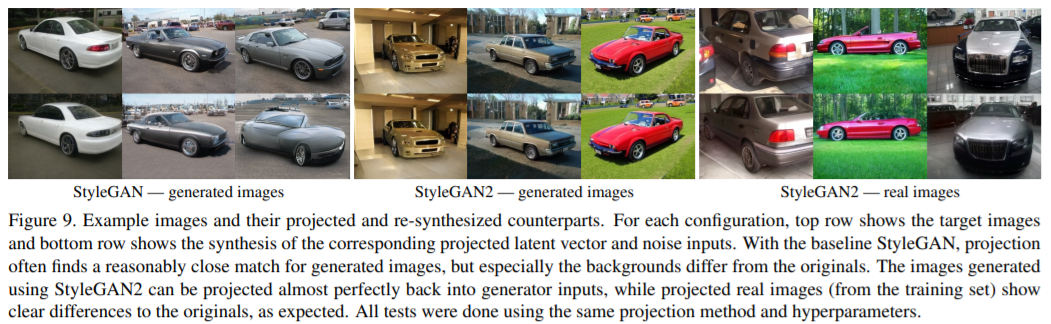

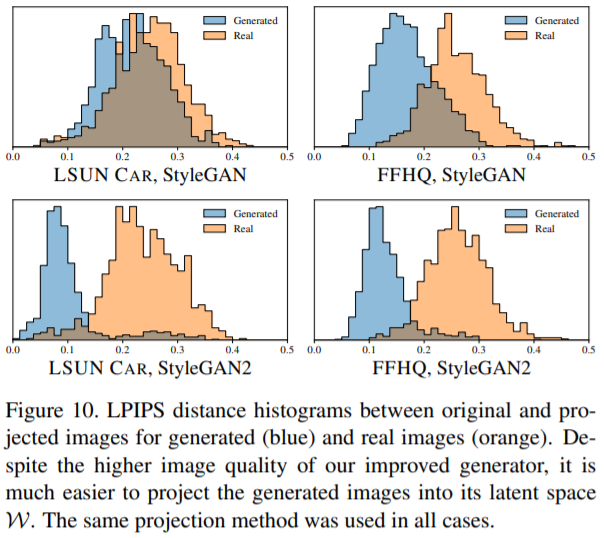

위의 그림 Figure 9과 10은 잠재 공간으로 투영하는 방법을 분석한 결과이다. 그림 Figure 10에서는 StyleGAN과 StyleGAN2에 대해 히스토그램으로 원본 image와 생성된 image 사이의 LPIPS 거리 분포를 보여준다. StyleGAN2가 PPL을 위하여 regularization term을 이용하여 잠재 공간의 smoothing을 확보하였기 때문에 StyleGAN과 실제 image보다 잠재 공간에 더 잘 투영이 된다.

그림 Figure 9에서는 이러한 예제 프로젝션을 보여준다(실제 image -> 잠재 공간에 투영 -> generator). StyleGAN에서는 재구성된 image가 몇몇 장소에서 실제 image와 다른 특징을 몇 가지 가졌지만, StyleGAN2에서는 더욱 잘 재구성이 된 것을 알 수 있다.